In [1]:
import torch
import numpy as np
import scipy.sparse as sp
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from dataset import DDDataset
from model import ModelA, ModelB

In [2]:
plt.style.use('fivethirtyeight')    # 将matplotlib设置为fivethirtyeight绘图风格

In [3]:
def tensor_from_numpy(x, device):
    return torch.from_numpy(x).to(device)


def normalization(adjacency):
    """
    L=D^-0.5 * (A+I) * D^-0.5
    :param adjacency:
    :return:
    """
    adjacency += sp.eye(adjacency.shape[0])
    degree = np.array(adjacency.sum(1))
    d_hat = sp.diags(np.power(degree, -0.5).flatten())
    L = d_hat.dot(adjacency).dot(d_hat).tocoo()
    indices = torch.from_numpy(np.asarray([L.row, L.col])).long()
    values = torch.from_numpy(L.data.astype(np.float32))
    tensor_adjacency = torch.sparse.FloatTensor(indices, values, L.shape)
    return tensor_adjacency

In [4]:
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

Device: cuda:0


In [5]:
dataset = DDDataset(data_root='../../GraphRNN/dataset/')

Loading DD_A.txt
Loading DD_node_labels.txt
Loading DD_graph_indicator.txt
Loading DD_graph_labels.txt
Number of nodes:  334925
Number of graphs:  1178
Number of edges:  1686092


In [6]:
# 模型输入数据准备
adjacency = dataset.sparse_adjacency
normalize_adjacency = normalization(adjacency).to(DEVICE)   # 邻接矩阵归一化
node_labels = tensor_from_numpy(dataset.node_labels, DEVICE)    # 节点标签
node_features = F.one_hot(node_labels, node_labels.max().item() + 1).float()    # 节点特征
graph_indicator = tensor_from_numpy(dataset.graph_indicator, DEVICE)    # 节点所属图
graph_labels = tensor_from_numpy(dataset.graph_labels, DEVICE)  # 图标签
train_index = tensor_from_numpy(dataset.train_index, DEVICE)    # 原始数据集按照train:test=8:2切分
test_index = tensor_from_numpy(dataset.test_index, DEVICE)
train_label = tensor_from_numpy(dataset.train_label, DEVICE)
test_label = tensor_from_numpy(dataset.test_label, DEVICE)

In [7]:
# 超参数设置
INPUT_DIM = node_features.size(1)
NUM_CLASSES = 2 # 图分类有2类
EPOCHS = 200    # 训练迭代次数
HIDDEN_DIM = 32 # 隐藏层个数
LEARNING_RATE = 0.01    # 学习率
WEIGHT_DECAY = 0.0001   # 衰减因子

In [8]:
# 模型初始化
model_g = ModelA(INPUT_DIM, HIDDEN_DIM, NUM_CLASSES).to(DEVICE)
model_h = ModelB(INPUT_DIM, HIDDEN_DIM, NUM_CLASSES).to(DEVICE)

model = model_g

criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.Adam(model.parameters(), LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [9]:
model.train()

ModelA(
  (gcn1): GraphConvolution (89 -> 32)
  (gcn2): GraphConvolution (32 -> 32)
  (gcn3): GraphConvolution (32 -> 32)
  (pool): SelfAttentionPooling(
    (attn_gcn): GraphConvolution (96 -> 1)
  )
  (fc1): Linear(in_features=192, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

In [10]:
losses_a = []
for epoch in range(EPOCHS):
    logits = model(normalize_adjacency, node_features, graph_indicator)
    loss = criterion(logits[train_index], train_label)  # 只对训练的数据计算损失值
    optimizer.zero_grad()
    loss.backward()  # 反向传播计算参数的梯度
    optimizer.step()  # 使用优化方法进行梯度更新
    train_acc = torch.eq(
        logits[train_index].max(1)[1], train_label).float().mean()
    # print("Epoch {:03d}: Loss {:.4f}, TrainAcc {:.4}".format(epoch, loss.item(), train_acc.item()))
    losses_a.append(loss.item())

In [11]:
model.eval()

ModelA(
  (gcn1): GraphConvolution (89 -> 32)
  (gcn2): GraphConvolution (32 -> 32)
  (gcn3): GraphConvolution (32 -> 32)
  (pool): SelfAttentionPooling(
    (attn_gcn): GraphConvolution (96 -> 1)
  )
  (fc1): Linear(in_features=192, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

In [12]:
with torch.no_grad():
    logits = model(normalize_adjacency, node_features, graph_indicator)
    test_logits = logits[test_index]
    test_acc = torch.eq(
        test_logits.max(1)[1], test_label
    ).float().mean()

print(test_acc.item())

0.7838982939720154


In [13]:
model = model_h
print("Device:", DEVICE)

criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.Adam(model.parameters(), LEARNING_RATE, weight_decay=WEIGHT_DECAY)

Device: cuda:0


In [14]:
model.train()

ModelB(
  (gcn1): GraphConvolution (89 -> 32)
  (pool1): SelfAttentionPooling(
    (attn_gcn): GraphConvolution (32 -> 1)
  )
  (gcn2): GraphConvolution (32 -> 32)
  (pool2): SelfAttentionPooling(
    (attn_gcn): GraphConvolution (32 -> 1)
  )
  (gcn3): GraphConvolution (32 -> 32)
  (pool3): SelfAttentionPooling(
    (attn_gcn): GraphConvolution (32 -> 1)
  )
  (mlp): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=2, bias=True)
  )
)

In [15]:
losses_b = []
for epoch in range(EPOCHS):
    logits = model(normalize_adjacency, node_features, graph_indicator)
    loss = criterion(logits[train_index], train_label)  # 只对训练的数据计算损失值
    optimizer.zero_grad()
    loss.backward()  # 反向传播计算参数的梯度
    optimizer.step()  # 使用优化方法进行梯度更新
    train_acc = torch.eq(
        logits[train_index].max(1)[1], train_label).float().mean()
    # print("Epoch {:03d}: Loss {:.4f}, TrainAcc {:.4}".format(epoch, loss.item(), train_acc.item()))
    losses_b.append(loss.item())

In [16]:
model.eval()

ModelB(
  (gcn1): GraphConvolution (89 -> 32)
  (pool1): SelfAttentionPooling(
    (attn_gcn): GraphConvolution (32 -> 1)
  )
  (gcn2): GraphConvolution (32 -> 32)
  (pool2): SelfAttentionPooling(
    (attn_gcn): GraphConvolution (32 -> 1)
  )
  (gcn3): GraphConvolution (32 -> 32)
  (pool3): SelfAttentionPooling(
    (attn_gcn): GraphConvolution (32 -> 1)
  )
  (mlp): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=2, bias=True)
  )
)

In [17]:
with torch.no_grad():
    logits = model(normalize_adjacency, node_features, graph_indicator)
    test_logits = logits[test_index]
    test_acc = torch.eq(
        test_logits.max(1)[1], test_label
    ).float().mean()

print(test_acc.item())

0.7542372941970825


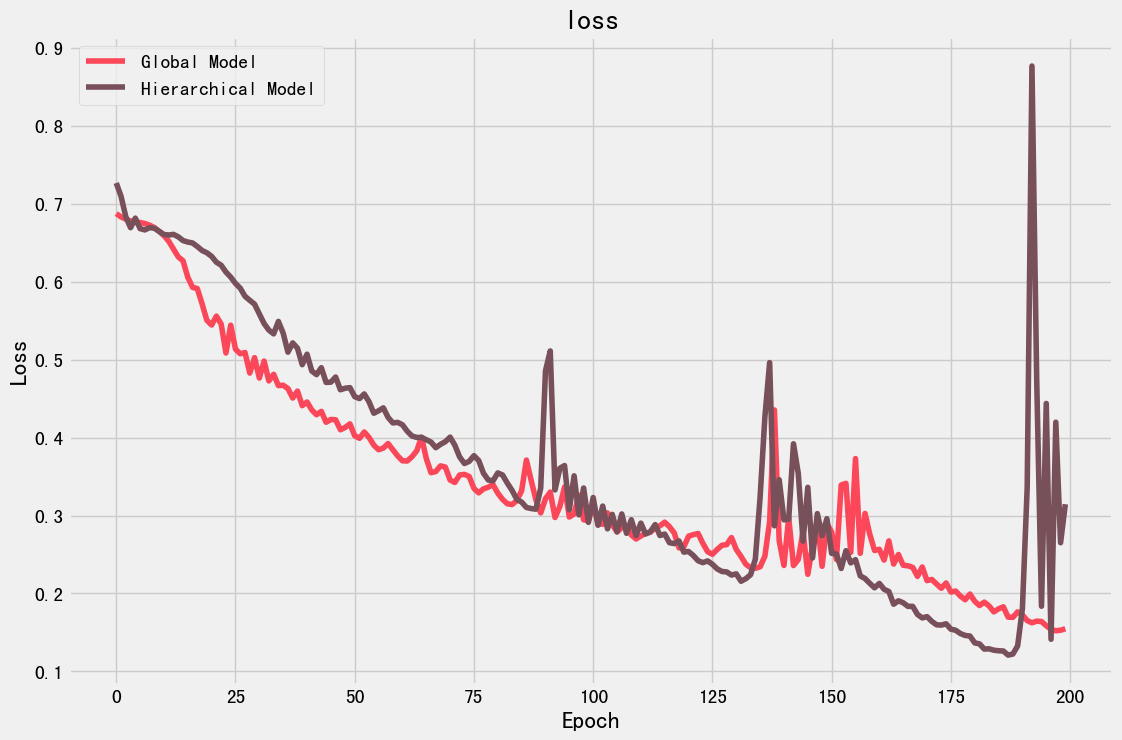

In [18]:
def plot_loss(loss_a, loss_b):
    plt.figure(figsize=(12, 8))
    plt.plot(range(len(loss_a)), loss_a, c=np.array([255, 71, 90]) / 255., label='Global Model')
    plt.plot(range(len(loss_b)), loss_b, c=np.array([120, 80, 90]) / 255., label='Hierarchical Model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc=0)
    plt.title('loss')
    plt.savefig("../assets/loss.png")
    plt.show()


plot_loss(losses_a, losses_b)